In [1]:
import yfinance as yf
import pandas as pd
from hmmlearn import hmm
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numba
from scipy.optimize import minimize
from tqdm import tqdm

In [2]:
ticker_name = "^SPX"
ticker = yf.Ticker(ticker_name)

interval = "1d"
intraday = False
if intraday:
    interval = "1h"
lr_scaler = 10 ** 3
# lr_scaler = StandardScaler()


df = pd.DataFrame()
while len(df) < 1:
    df = ticker.history(period="max", interval=interval)[["Open", "High", "Low", "Close", "Volume"]]


df["Log_Returns"] = (np.log(df['Close'] / df['Close'].shift(1)))
df = df[1:]

# df["Log_Returns"] = lr_scaler.fit_transform(df[["Log_Returns"]])

#df["Volume_Change"] = np.log(df["Volume"]) - np.log(df["Volume"].shift(1))
df = df[1:]

df.to_csv(f"{ticker_name}_{interval}.csv")
sim_config = {
    "ticker": ticker_name,
    "interval": interval,   
    "lr_scaler": lr_scaler,
}
with open("config.txt", "w") as f:
    f.write(str(sim_config))
df.describe()

,Open,High,Low,Close,Volume,Log_Returns
count,24455.000000,24455.000000,24455.000000,24455.000000,2.445500e+04,24455.000000
mean,657.395960,681.016756,672.834524,677.189586,9.346211e+08,0.000237
std,1137.185119,1132.691314,1119.750652,1126.647825,1.645414e+09,0.011977
min,0.000000,4.400000,4.400000,4.400000,0.000000e+00,-0.228997
25%,9.780000,24.799999,24.799999,24.799999,1.570000e+06,-0.004562
50%,43.889999,103.750000,102.089996,102.919998,2.111000e+07,0.000493
75%,1065.429993,1073.740051,1057.404968,1065.789978,1.085850e+09,0.005459
max,6134.500000,6147.430176,6111.149902,6144.149902,1.145623e+10,0.153661


In [3]:
sim_config["lr_scaler"] = lr_scaler
df["Log_Returns"] = df["Log_Returns"] * lr_scaler

df["Log_Returns_sq"] = df["Log_Returns"] ** 2
df["Log_Returns_abs"] = abs(df["Log_Returns"])
df["High-Low"] = df["High"] - df["Low"]
df["Close-Open"] = df["Close"] - df["Open"]
#df["VIX"] = vix_df["Adj Close"]
#df["VIX_Log_Returns"] = np.log(df["VIX"] / df["VIX"].shift(1))

train, test = train_test_split(df, test_size=0.2, shuffle=False)

train["Log_Returns"].describe()

count    19564.000000
mean         0.218034
std         11.865577
min       -228.997286
25%         -4.634233
50%          0.430813
75%          5.368799
max        153.661289
Name: Log_Returns, dtype: float64

In [4]:
features = ["Log_Returns"]

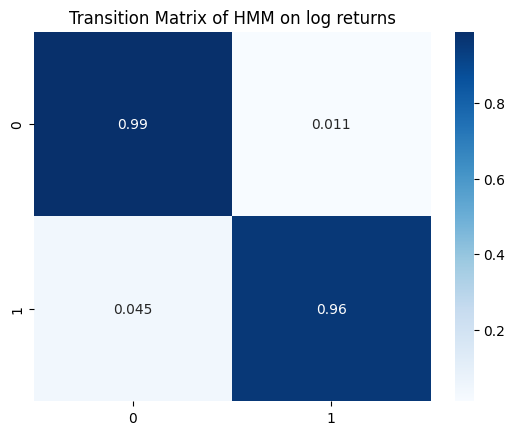

In [5]:
is_scaled = False
if is_scaled:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[features].values.reshape(-1, 1))
    X_test = scaler.transform(test[features].values.reshape(-1, 1))
else:
    # dont scale
    X_train = train[features].values.reshape(-1, 1)
    X_test = test[features].values.reshape(-1, 1)

model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
model.fit(X_train)

y_train = model.predict(X_train)
y_test = model.predict(X_test)

train["State"] = y_train
test["State"] = y_test

sns.heatmap(model.transmat_, annot=True, cmap="Blues")
plt.title("Transition Matrix of HMM on log returns")
plt.show()

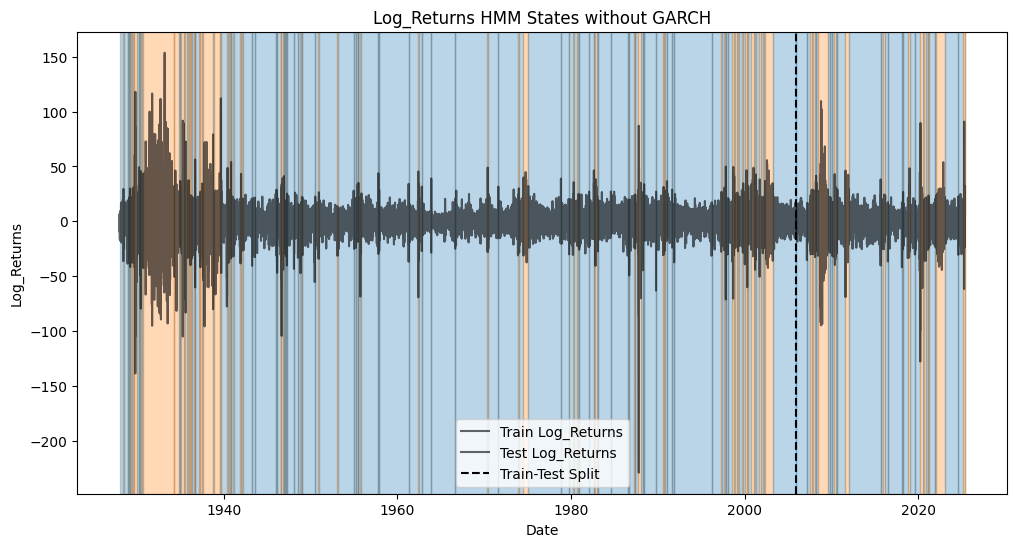

In [6]:
state_colors = {i: sns.color_palette()[i] for i in range(model.n_components)}
target = features[0]
# Plot the adjusted close price as a line
plt.figure(figsize=(12, 6))
plt.plot(train.index, train[target], label=f'Train {target}', color='black', alpha=0.6)
plt.plot(test.index, test[target], label=f'Test {target}', color='black', alpha=0.6)

# Function to plot shaded regions for each state
def plot_state_regions(df, state_colors):
    current_state = df["State"].iloc[0]
    start_date = df.index[0]

    for date, state in zip(df.index, df["State"]):
        if state != current_state:
            # Plot the shaded region for the current state
            plt.axvspan(start_date, date, color=state_colors[current_state], alpha=0.3)
            # Update to the new state and start date
            current_state = state
            start_date = date

    # Plot the last region
    plt.axvspan(start_date, df.index[-1], color=state_colors[current_state], alpha=0.3)

# Plot shaded regions for both train and test dfsets
plot_state_regions(train, state_colors)
plot_state_regions(test, state_colors)

# Add a vertical line to indicate the train-test split
split_date = test.index[0]
plt.axvline(x=split_date, color='black', linestyle='--', label='Train-Test Split')

# Add labels and legend
plt.title(f"{'Scaled ' if is_scaled else ''}{target} HMM States without GARCH")
plt.xlabel("Date")
plt.ylabel(f"{target}")
plt.legend()
plt.show()

In [7]:
import numba
import numpy as np

@numba.jit(nopython=True)
def normal_pdf(x, mu, sigma):
    """
    Returns Normal(mu, sigma) pdf evaluated at x.
    Numba-friendly: no Python objects or extra checks.
    """
    eps = 1e-16
    sigma = max(sigma, eps)  # avoid zero stdev
    const = 1.0 / (np.sqrt(2.0 * np.pi) * sigma)
    z = (x - mu) / sigma
    return const * np.exp(-0.5 * z * z)

@numba.njit
def stationary_2x2(P):
    """
    Computes the stationary distribution of a 2x2 Markov chain:
        P = [[p00, 1-p00],
             [1-p11, p11]]
    Returns a length-2 array [pi0, pi1].
    """
    p00 = P[0, 0]
    p11 = P[1, 1]
    
    # denominator = 2 - (p00 + p11)
    denom = 2.0 - p00 - p11
    
    # Handle degenerate or invalid transitions
    if abs(denom) < 1e-15:
        # e.g. if p00 + p11 == 2 exactly, the chain might be degenerate
        # You can either raise an error or return something default
        return np.array([0.5, 0.5])  # fallback or raise an exception
    
    pi0 = (1.0 - p11) / denom
    pi1 = (1.0 - p00) / denom
    
    return np.array([pi0, pi1], dtype=np.float64)

@numba.jit(nopython=True)
def rs_garch_filter(
    data,      # shape (T,)
    P,         # shape (2,2) transition matrix
    means,     # shape (2,) => [mu0, mu1]
    omega,     # shape (2,) => [omega0, omega1]
    alpha,     # shape (2,) => [alpha0, alpha1]
    beta,      # shape (2,) => [beta0,  beta1]
    var0       # shape (2,) => initial variances [var0_state0, var0_state1]
):
    """
    Numba-jitted 2-state Regime-Switching GARCH(1,1) forward filter.

    Parameters
    ----------
    data : float ndarray (T,)
        Observed time series (e.g. log returns).
    P : float ndarray (2,2)
        Transition matrix, e.g. [[p00, 1-p00],
                                 [1-p11, p11]].
    means, omega, alpha, beta, var0 : float ndarray(2,)
        Each of length 2, storing the state-dependent parameters.

    Returns
    -------
    pi_filt : ndarray (T, 2)
        Posterior state probabilities at each time t.
    sigma2  : ndarray (T, 2)
        The GARCH(1,1) conditional variances for each state at each t.
    logL    : float
        The total log-likelihood, sum of log( predictive densities ).
    """
        
    T = data.shape[0]
    
    # Posterior probabilities pi_{t|t}(k)
    pi_filt = np.zeros((T, 2))
    
    # GARCH conditional variances: sigma2[t,k] for each time/state
    sigma2 = np.zeros((T, 2))
    
    # 1) Initialization
    # Posterior at t=0 (common approach: uniform or stationary)
    # pi_filt[0, 0] = 0.5
    # pi_filt[0, 1] = 0.5
    P_stationary = stationary_2x2(P)
    pi_filt[0,:] = P_stationary

    # Initialize variance in each state
    sigma2[0, 0] = var0[0]
    sigma2[0, 1] = var0[1]
    
    # Evaluate emission at t=0
    eps = 1e-16
    f0_0 = normal_pdf(data[0], means[0], np.sqrt(sigma2[0, 0]))
    f0_1 = normal_pdf(data[0], means[1], np.sqrt(sigma2[0, 1]))
    ell_0 = pi_filt[0,0]*f0_0 + pi_filt[0,1]*f0_1
    
    # Posterior update at t=0
    denom = ell_0 + eps
    pi_filt[0,0] = (pi_filt[0,0] * f0_0) / denom
    pi_filt[0,1] = (pi_filt[0,1] * f0_1) / denom
    
    # Log-likelihood so far
    logL = np.log(ell_0 + eps)
    
    # 2) Forward filter for t=1..T-1
    for t in range(1, T):
        # --- GARCH recursion for each state k ---
        # sigma2[t,k] = omega[k] + alpha[k]*(data[t-1] - means[k])^2 + beta[k]*sigma2[t-1,k]
        sigma2[t, 0] = (omega[0]
                        + alpha[0] * (data[t-1] - means[0])**2
                        + beta[0]  * sigma2[t-1, 0])
        sigma2[t, 1] = (omega[1]
                        + alpha[1] * (data[t-1] - means[1])**2
                        + beta[1]  * sigma2[t-1, 1])
        
        # --- Prediction step ---
        pi_pred_0 = pi_filt[t-1, 0]*P[0,0] + pi_filt[t-1, 1]*P[1,0]
        pi_pred_1 = pi_filt[t-1, 0]*P[0,1] + pi_filt[t-1, 1]*P[1,1]
        
        # --- Emission probabilities at t for each state ---
        f_t0 = normal_pdf(data[t], means[0], np.sqrt(sigma2[t, 0]))
        f_t1 = normal_pdf(data[t], means[1], np.sqrt(sigma2[t, 1]))
        
        # predictive density
        ell_t = pi_pred_0*f_t0 + pi_pred_1*f_t1
        denom = ell_t + eps
        
        # --- Update step ---
        pi_filt[t, 0] = (pi_pred_0 * f_t0) / denom
        pi_filt[t, 1] = (pi_pred_1 * f_t1) / denom
        
        # Accumulate log-likelihood
        logL += np.log(ell_t + eps)
    
    return pi_filt, sigma2, logL


In [8]:
def objective(theta, data, P):
    """
    theta = [
        means[0], means[1],
        omega[0], omega[1],
        alpha[0], alpha[1],
        beta[0],  beta[1],
        var0[0],  var0[1],
        p00,      p11
    ]
    """
    means = np.array([theta[0], theta[1]])
    omega = np.array([theta[2], theta[3]])
    alpha = np.array([theta[4], theta[5]])
    beta  = np.array([theta[6], theta[7]])
    var0  = omega / (1 - alpha - beta)
    if np.any(var0 < 0):
        return np.inf
    if np.any(np.isnan(var0)):
        return np.inf
    
    pi_filt, sigma2, logL = rs_garch_filter(data, P, means, omega, alpha, beta, var0)
    return -logL  # negative log-likelihood


In [9]:
from scipy.optimize import minimize

# theta0 = np.array([
#     0.0,   0.0,     # means
#     0.00001,   0.01,     # omega - encourage one state to have higher volatility than the other
#     0.045,  0.15,    # alpha
#     0.945,   0.65,     # beta
# ])

theta0 = np.array([
    0.0,   0.0,     # means
    1e-6,   1e-4,     # omega - encourage state 1 to have higher volatility than mean 0
    0.05,  0.2,    # alpha
    0.9,   0.75,     # beta
])

bnds = [
    (None,None),   # mean0
    (None,None),   # mean1
    (1e-6,None), (1e-6,None),   # omega
    (0,1), (0,1),               # alpha
    (0,1), (0,1),               # beta
]

p00_grid = np.linspace(0.01, 0.99, 100)
p11_grid = np.linspace(0.01, 0.99, 100)
best_p00 = None
best_p11 = None
best_obj = np.inf
best_res = None
for p00 in p00_grid:
    for p11 in p11_grid:
        P = np.array([
            [p00,      1 - p00],
            [1 - p11,  p11    ]
        ])
        res = minimize(
            objective,
            theta0,
            args=(train["Log_Returns"].values, P),
            method='L-BFGS-B',
            bounds=bnds
        )
        if res.fun < best_obj:
            best_obj = res.fun
            best_p00 = p00
            best_p11 = p11
            best_res = res
            print(f"New best: p00={p00}, p11={p11}, obj={res.fun}")

print(f"Best p00={best_p00}, p11={best_p11}, obj={best_obj}")

New best: p00=0.01, p11=0.01, obj=720764.3961492804
Best p00=0.01, p11=0.01, obj=720764.3961492804


In [10]:
res = best_res
means = res.x[:2] / lr_scaler
omegas = res.x[2:4] / lr_scaler ** 2
alphas = res.x[4:6]
betas  = res.x[6:8]
var0   = omegas / (1 - alphas - betas)
P = np.array([
    [best_p00,      1 - best_p00],
    [1 - best_p11,  best_p11    ]
])

alphas + betas, var0, omegas / (1-alphas - betas) # first state is stationary with low var. second state is explosive with high var

(array([0.95, 0.95]), array([2.e-11, 2.e-09]), array([2.e-11, 2.e-09]))

In [11]:
params = pd.DataFrame({
    "Mean": means,
    "Omega": omegas,
    "Alpha": alphas,
    "Beta": betas,
    "p": [best_p00, best_p11]
})
params.to_csv(f"ms_garch_params.csv")
params

,Mean,Omega,Alpha,Beta,p
0,0.0,1.000000e-12,0.05,0.90,0.01
1,0.0,1.000000e-10,0.20,0.75,0.01


In [12]:
lr_scaler

1000

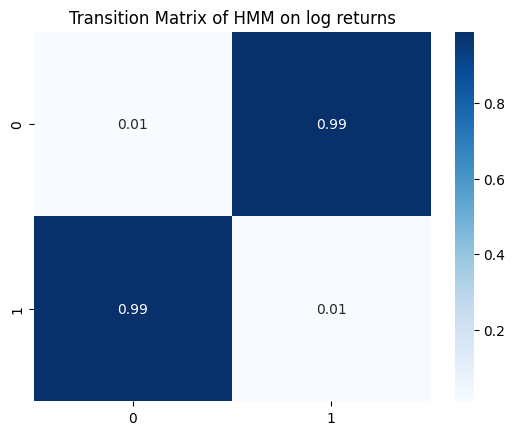

In [13]:
sns.heatmap(P, annot=True, cmap="Blues")
plt.title("Transition Matrix of HMM on log returns")
plt.show()